# Sentiments analysis

Find all the mentions of world countries in the whole corpus, using the pycountry utility (HINT: remember that there will be different surface forms for the same country in the text, e.g., Switzerland, switzerland, CH, etc.) Perform sentiment analysis on every email message using the demo methods in the nltk.sentiment.util module. Aggregate the polarity information of all the emails by country, and plot a histogram (ordered and colored by polarity level) that summarizes the perception of the different countries. Repeat the aggregation + plotting steps using different demo methods from the sentiment analysis module -- can you find substantial differences?


In [75]:
import pandas as pd                                     
import numpy as np                                      
import os                         


import matplotlib.pyplot as plt

from datetime import datetime

%matplotlib inline
import seaborn as sns

import pycountry

# Create the country list

The first thing to do is to establish a list with all countries, and for each country, we want to obtain a maximum amount of different form (e.g. Switzerland, CH, Swiss Confederation, etc...).

## Getting list from pycountry

We therefore use the pycountry utility and create a DataFrame with all existing names for each countries

In [76]:
countries = []
no_official = 0
tot = 0
for country in pycountry.countries:
    tot += 1
    official_name = None
    try:
        official_name = country.official_name
    except:
        no_official += 1
        
    countries.append([country.alpha_2, country.alpha_3, country.name, official_name])
    
countries_df = pd.DataFrame(countries)
countries_df.columns = ["Alpha2", "Alpha3", "English Name", "Official Name"]

print(no_official, "countries without official name, on a total of", tot, "countries")
countries_df.head()

76 countries without official name, on a total of 249 countries


,Alpha2,Alpha3,English Name,Official Name
0,AW,ABW,Aruba,None
1,AF,AFG,Afghanistan,Islamic Republic of Afghanistan
2,AO,AGO,Angola,Republic of Angola
3,AI,AIA,Anguilla,None
4,AX,ALA,Åland Islands,None


## Data Cleaning

We observed that some countries, like the Åland Islands, have accents in their names, we therefore decide to remove all accents. (And we'll do so for the mails content).

In [77]:
countries_df[countries_df["Alpha2"] == "AX"]

,Alpha2,Alpha3,English Name,Official Name
4,AX,ALA,Åland Islands,None


In [78]:
import unicodedata

def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return u"".join([c for c in nfkd_form if not unicodedata.combining(c)])

In [79]:
for country in countries_df:
    for i in range (len(countries_df[country])):
        if countries_df[country][i] != None:
            countries_df[country][i] = remove_accents(countries_df[country][i])
countries_df.head()

,Alpha2,Alpha3,English Name,Official Name
0,AW,ABW,Aruba,None
1,AF,AFG,Afghanistan,Islamic Republic of Afghanistan
2,AO,AGO,Angola,Republic of Angola
3,AI,AIA,Anguilla,None
4,AX,ALA,Aland Islands,None


In [80]:
countries_df[countries_df["Alpha2"] == "AX"]

,Alpha2,Alpha3,English Name,Official Name
4,AX,ALA,Aland Islands,None


## Official Names Evaluation

We observe that a large amount of countries does not have an official name in pycountry. We want to evaluate the official names we obtained in order to decide wether to keep them, and in this case, how to treat them.

We then compute a DataFrame containing only countries for which we obtained the official name.

In [81]:
countries_with_official_names = countries_df[countries_df["Official Name"].notnull()]
print("Number of countries with official names", len(countries_with_official_names))
countries_with_official_names.head()

Number of countries with official names 173


,Alpha2,Alpha3,English Name,Official Name
1,AF,AFG,Afghanistan,Islamic Republic of Afghanistan
2,AO,AGO,Angola,Republic of Angola
5,AL,ALB,Albania,Republic of Albania
6,AD,AND,Andorra,Principality of Andorra
8,AR,ARG,Argentina,Argentine Republic


We expect most of the official names of the countries to contains only a copy of the simple name with some prefix like "Republic of", "State of", etc...

But maybe some official names may contains different information, we therefore compute the countries with an official names that do not contains the simple english name.

In [82]:
contained_filter = countries_with_official_names.apply(lambda x: x['English Name'].lower() not in x['Official Name'].lower(), axis=1)
print("Number of official name with new information", len(countries_with_official_names[contained_filter]), "/", len(countries_with_official_names))
countries_with_official_names[contained_filter]

Number of official name with new information 23 / 173


,Alpha2,Alpha3,English Name,Official Name
8,AR,ARG,Argentina,Argentine Republic
31,BO,BOL,"Bolivia, Plurinational State of",Plurinational State of Bolivia
41,CH,CHE,Switzerland,Swiss Confederation
58,CZ,CZE,Czechia,Czech Republic
75,FR,FRA,France,French Republic
77,FM,FSM,"Micronesia, Federated States of",Federated States of Micronesia
89,GR,GRC,Greece,Hellenic Republic
107,IR,IRN,"Iran, Islamic Republic of",Islamic Republic of Iran
111,IT,ITA,Italy,Italian Republic
118,KG,KGZ,Kyrgyzstan,Kyrgyz Republic


We observe that most of this official names contains in fact adjective of the country. We now have to chose wether to keep this new information, or discard them.

If we chose to consider the usage of a country adjective in Hillary Clinton's mail as a reference for the country, this could lead to large bias. For example, if she mention "swiss cheese" or "swiss knife" in one of her mail, this would be associated to the country Switzerland, even if the content of the mail does not represent the sentiment toward the country.

We decide then to **discard the adjective**, and we'll use only the simple english name of country.

*ps: Note that some official names contains interesting info, like **Hellenic Republic for Greece** for example, which is a total different expression. But we chose to discard these informations because we think that these expression are not use in a regular basis and won't be used in the mail to denote the countries*

In [83]:
countries_df = countries_df.drop(["Official Name"],1)

## Countries Names Analysis

We now want to analyse the simple name of the countries, in order to now how to treat them and how to use their words to associate the mails to the countries.

For this purpose, we start by looking at the composed names.

In [84]:
composed_filter = countries_df.apply(lambda x: len(x['English Name'].split(" ")) > 1, axis=1)
print("Number of composed names", len(countries_df[composed_filter]), "/", len(countries_df))
countries_df[composed_filter]

Number of composed names 80 / 249


,Alpha2,Alpha3,English Name
4,AX,ALA,Aland Islands
7,AE,ARE,United Arab Emirates
10,AS,ASM,American Samoa
12,TF,ATF,French Southern Territories
13,AG,ATG,Antigua and Barbuda
20,BQ,BES,"Bonaire, Sint Eustatius and Saba"
21,BF,BFA,Burkina Faso
26,BA,BIH,Bosnia and Herzegovina
27,BL,BLM,Saint Barthelemy
31,BO,BOL,"Bolivia, Plurinational State of"


We notice some things that need to be treated in the countries names : 
* Some names contains comma
* Some names contains parenthesis
* Some names contain "Republic" in it

### Names with comma

We noticed that some names contain comma. We want to take a look at them and treat them properly.

In [85]:
comma_index = countries_df["English Name"].str.contains(",")
countries_df[comma_index]

,Alpha2,Alpha3,English Name
20,BQ,BES,"Bonaire, Sint Eustatius and Saba"
31,BO,BOL,"Bolivia, Plurinational State of"
46,CD,COD,"Congo, The Democratic Republic of the"
77,FM,FSM,"Micronesia, Federated States of"
107,IR,IRN,"Iran, Islamic Republic of"
122,KR,KOR,"Korea, Republic of"
139,MD,MDA,"Moldova, Republic of"
144,MK,MKD,"Macedonia, Republic of"
181,KP,PRK,"Korea, Democratic People's Republic of"
184,PS,PSE,"Palestine, State of"


We observe that these names (except for Bonaire, Sint Eustatius and Saba) contains only adjective after the comma. We can simply keep the first part and discard the rest.

*We consider that "Bonaire, Sint Eustatius and Saba" can be discarded and therefore do not treat it differently*

In [86]:
countries_df["English Name"] = countries_df["English Name"].map(lambda x: x.split(",")[0])
countries_df[comma_index].head()

,Alpha2,Alpha3,English Name
20,BQ,BES,Bonaire
31,BO,BOL,Bolivia
46,CD,COD,Congo
77,FM,FSM,Micronesia
107,IR,IRN,Iran


### Country with parenthesis

We decide to remove what is inside parenthesis of the countries names.

In [87]:
import re
par_index = countries_df["English Name"].apply(lambda x: "(" in str(x))
countries_df["English Name"] = countries_df["English Name"].map(lambda x: re.sub(r'\([^)]*\)', '', x))
countries_df[par_index].head()

,Alpha2,Alpha3,English Name
40,CC,CCK,Cocos Islands
74,FK,FLK,Falkland Islands
136,MF,MAF,Saint Martin
212,SX,SXM,Sint Maarten
236,VA,VAT,Holy See


## Countries with same names

Unfortunately for us, there are countries that share the same name, or a same part.

* North Korea and South Korea
* Republic of Congo and Democratic Republic of Congo
* Ireland and Northern Ireland
* US Virgin Islands and UK Virgin Islands


### Koreas

In [88]:
countries_df[countries_df["English Name"].str.contains("Korea")]

,Alpha2,Alpha3,English Name
122,KR,KOR,Korea
181,KP,PRK,Korea


In the case of Koreas, after our cleaning, we see that both countries have exactly the same name. Therefore, we decide to replace them by their most commonly used name : North Korea and South Korea.

In [89]:
countries_df.loc[122]["English Name"] = "South Korea"
countries_df.loc[181]["English Name"] = "North Korea"
countries_df[countries_df["English Name"].str.contains("Korea")]

,Alpha2,Alpha3,English Name
122,KR,KOR,South Korea
181,KP,PRK,North Korea


## Congos

Unfortunately, unless like Koreas, we expect to have no way to distinguish Republic of Congo and Democratic Republic of Congo, since people usually simply call them both "Congo". We therefore chose to let them both as "Congo" and hope that it doesn't appear too often in the mails. If it is not the case, we'll try to treat them in a more clever way later on.

In [90]:
countries_df[countries_df["English Name"].str.contains("Congo")]

,Alpha2,Alpha3,English Name
46,CD,COD,Congo
47,CG,COG,Congo


## Virgin Islands

As for Congos, we will let them both as "Virgin Islands" and expect not to have troubles with them.

In [91]:
countries_df[countries_df["English Name"].str.contains("Virgin")]

,Alpha2,Alpha3,English Name
239,VG,VGB,Virgin Islands
240,VI,VIR,Virgin Islands


## The curious case of British Isles

We all know it, Brits are a little bit special. We can see on the following map that the administration of the British isles is a bit complex. 

Since the countries in these Isles (England, Ireland, Wales, Northern Ireland, Scottland, etc...) have a relevant impact on the political world, we want to be sure to detect them properly in the mails.

<img src="images/British_Isles_terms.gif" alt="Drawing" style="width: 420px;"/>

In [92]:
countries_df[countries_df["Alpha2"] == "UK"]

,Alpha2,Alpha3,English Name


In [93]:
countries_df[countries_df["Alpha2"] == "GB"]

,Alpha2,Alpha3,English Name
79,GB,GBR,United Kingdom


In [94]:
pycountry.countries.get(alpha_2 = "GB")

Country(alpha_2='GB', alpha_3='GBR', name='United Kingdom', numeric='826', official_name='United Kingdom of Great Britain and Northern Ireland')

We notice that the Alpha 2 "UK" is not used to denote the United Kingdom, but "GB" is used, event if the country really is the United Kingdom, containing England, Wales, Scottland and Northern Ireland.
We will need to add manually keywords if we want to be sure to detect all mentions of these countries in the mails.

In [95]:
countries_df[countries_df["English Name"].str.contains("Ireland")]

,Alpha2,Alpha3,English Name
106,IE,IRL,Ireland


We observe that only (Southern) Ireland is accociated to word Ireland

## Other weird stuffs

We still have 69 composed names, there must be unclean names in this list. We will try to see which one shoud not be composed and replace them by the most common simple name (e.g. Russian Federation must be replaced by Russia, because it is the most common way of calling it).

In [96]:
composed_filter = countries_df.apply(lambda x: len(x['English Name'].split(" ")) > 1, axis=1)
print("Number of composed names", len(countries_df[composed_filter]), "/", len(countries_df))

Number of composed names 69 / 249


In [97]:
countries_df[composed_filter][countries_df[composed_filter]["English Name"].str.contains("Republic")]

,Alpha2,Alpha3,English Name
38,CF,CAF,Central African Republic
63,DO,DOM,Dominican Republic
124,LA,LAO,Lao People's Democratic Republic
214,SY,SYR,Syrian Arab Republic


In [98]:
#We choose to keep Central African Republic and Dominican Republic
countries_df.loc[124]["English Name"] = "Laos"
countries_df.loc[214]["English Name"] = "Syria"

In [99]:
countries_df[composed_filter][countries_df[composed_filter]["English Name"].str.contains("Kingdom")]

,Alpha2,Alpha3,English Name
79,GB,GBR,United Kingdom


In [100]:
countries_df[composed_filter][countries_df[composed_filter]["English Name"].str.contains("Federation")]

,Alpha2,Alpha3,English Name
189,RU,RUS,Russian Federation


In [101]:
countries_df.loc[189]["English Name"] = "Russia"

In [102]:
countries_df[composed_filter][countries_df[composed_filter]["English Name"].str.contains("Arab")]

,Alpha2,Alpha3,English Name
7,AE,ARE,United Arab Emirates
191,SA,SAU,Saudi Arabia


In [103]:
countries_df[composed_filter][countries_df[composed_filter]["English Name"].str.contains("Fr")]

,Alpha2,Alpha3,English Name
12,TF,ATF,French Southern Territories
93,GF,GUF,French Guiana
185,PF,PYF,French Polynesia


In [104]:
countries_df[composed_filter][countries_df[composed_filter]["English Name"].str.contains("Amer")]

,Alpha2,Alpha3,English Name
10,AS,ASM,American Samoa


In [105]:
countries_df[composed_filter][countries_df[composed_filter]["English Name"].str.contains("Brit")]

,Alpha2,Alpha3,English Name
105,IO,IOT,British Indian Ocean Territory


In [106]:
countries_df[composed_filter][countries_df[composed_filter]["English Name"].str.contains("Iv")]

,Alpha2,Alpha3,English Name
44,CI,CIV,Cote d'Ivoire


In [107]:
countries_df.loc[44]["English Name"] = "Ivory Coast"

In [108]:
composed_filter = countries_df.apply(lambda x: len(x['English Name'].split(" ")) > 1, axis=1)
print("Number of composed names", len(countries_df[composed_filter]), "/", len(countries_df))

Number of composed names 66 / 249


We consider now the remaining composed countries name correct. This means that we assume that we can search for the complete composed name in the mails, and won't have to use each part of the name.

e.g. We will look for occurences of "United Kingdom", this way, and won't consider occurence of "Kingdom" or "United" as reference to this country.

# Conversion into dictionary

We now convert our keywords into a dictionnary, that will help to link all the keywords to the proper country.

## Edit
*Unfortunately, we obtained bad result using Alpha2 and Alpha3. We had a lot of mails linked to Andorra for example, because the Alpha3 of Andorra is "and" which is confused with the english word "and" which is recurrent in the mails as we can expect. We therefore took the decision to removes the Alpha2 and Alpha3 that could cause problem.

In [324]:
countries_dict = {}
idx = 0
for col in countries_df:
#for col in ["English Name"]:
    for i in range(len(countries_df[col])):
        try :
            if countries_dict[countries_df[col][i]] != None:
                print(countries_df[col][i], "has duplicated index")
        except : 
            idx+=1
        countries_dict[str(countries_df[col][i]).lower()] = countries_df["English Name"][i]
        
countries_dict.pop('and', None)
countries_dict.pop('an', None)
countries_dict.pop('am', None)
countries_dict.pop('be', None)
countries_dict.pop('nor', None)
countries_dict.pop('are', None)
countries_dict.pop('my', None)
countries_dict.pop('by', None)
countries_dict.pop('at', None)
countries_dict.pop('do', None)
countries_dict.pop('per', None)
countries_dict.pop('to', None)
countries_dict.pop('re', None)
countries_dict.pop('is', None)
countries_dict.pop('so', None)
countries_dict.pop('me', None)
countries_dict.pop('ago', None)
countries_dict.pop('can', None)
countries_dict.pop('no', None)
countries_dict.pop('pm', None)
countries_dict.pop('it', None)
countries_dict.pop('as', None)
countries_dict.pop('in', None)
countries_dict.pop('us', None)
countries_dict.pop('tv', None)
countries_dict.pop('st', None)
countries_dict.pop('ms', None)
countries_dict.pop('tv', None)
countries_dict.pop('mr', None)
countries_dict.pop('id', None)
countries_dict.pop('im', None)
countries_dict.pop('sen', None)
countries_dict.pop('al', None)
countries_dict.pop('fm', None)
countries_dict.pop('de', None)

'Germany'

## Adding keywords

We add manually some terms we expect Hillary Clinton to use to mention some countries.

In [233]:
countries_dict["Salvador".lower()] = "El Salvador"
countries_dict["Chinese Governement".lower()] = "China"
countries_dict["Russian Governement".lower()] = "Russia"

# Sentiment Analysis

To perform the sentiment analysis of the mails, we use the SentimentIntensityAnalyzer module of nltk.

In [111]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

In [112]:
#Used to download vader lexicon
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [115]:
sid = SentimentIntensityAnalyzer()

In [132]:
#Check that analyzer works
sentences = []
sentences.append("I love Switzerland, I have a lot of bank accounts there.")
sentences.append("I don't really like France, Paris stinks and french people can't stop talking about themselves.")
for sentence in sentences:
    print(sentence)
    ss = sid.polarity_scores(sentence)
    print(ss["compound"])

I love Switzerland, I have a lot of bank accounts there.
0.6369
I don't really like France, Paris stinks and french people can't stop talking about themselves.
-0.3482


The compound value of the polarity gives a negative value between 0 and -1.0 if the sentence is negative and a positive value between 0 and 1.0 if the sentence has a positive connotation.

# Perform on every mails

In [291]:
mails = pd.read_csv("hillary-clinton-emails/Emails.csv")
mails.head(3)

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,...,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...


In [292]:
mailsBody = mails[mails["ExtractedBodyText"].notnull()][["ExtractedSubject","ExtractedBodyText"]]
mailsBody.head()

,ExtractedSubject,ExtractedBodyText
1,NaN,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest..."
2,Re: Chris Stevens,Thx
4,NaN,"H <hrod17@clintonemail.com>\nFriday, March 11,..."
5,Meet The Right Wing Extremist Behind Anti-Musl...,Pis print.\n-•-...-^\nH < hrod17@clintonernail...
7,NaN,"H <hrod17@clintonemail.corn>\nFriday, March 11..."


In [295]:
#mailsBody["polarity"] = mailsBody["ExtractedBodyText"].apply(lambda x: sid.polarity_scores(x)["compound"])
#mailsBody.to_csv("data/bodies_with_polarity.csv")
mailsBody = pd.read_csv("data/bodies_with_polarity.csv")
mailsBody.head()

,Unnamed: 0,ExtractedSubject,ExtractedBodyText,polarity
0,1,NaN,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",0.0000
1,2,Re: Chris Stevens,Thx,0.3612
2,4,NaN,"H <hrod17@clintonemail.com>\nFriday, March 11,...",0.0000
3,5,Meet The Right Wing Extremist Behind Anti-Musl...,Pis print.\n-•-...-^\nH < hrod17@clintonernail...,-0.8402
4,7,NaN,"H <hrod17@clintonemail.corn>\nFriday, March 11...",0.0000


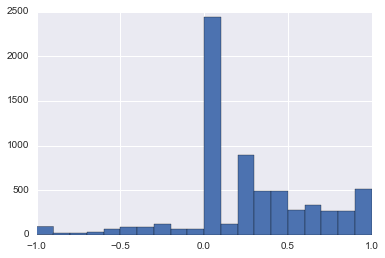

In [296]:
mailsBody.polarity.hist(bins=20)

## Cleaning bodies

In [318]:
import re

mailsBody["Cleaned body"] = mailsBody["ExtractedBodyText"].apply(lambda x: remove_accents(x)).apply(lambda x: x.lower()).apply(lambda x: " " + re.sub('[^0-9a-zA-Z ]+', '', x) + " ")

In [319]:
mailsBody.head()

,Unnamed: 0,ExtractedSubject,ExtractedBodyText,polarity,Cleaned body
0,1,NaN,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",0.0000,b6thursday march 3 2011 945 pmh latest how sy...
1,2,Re: Chris Stevens,Thx,0.3612,thx
2,4,NaN,"H <hrod17@clintonemail.com>\nFriday, March 11,...",0.0000,h hrod17clintonemailcomfriday march 11 2011 1...
3,5,Meet The Right Wing Extremist Behind Anti-Musl...,Pis print.\n-•-...-^\nH < hrod17@clintonernail...,-0.8402,pis printh hrod17clintonernailcomwednesday s...
4,7,NaN,"H <hrod17@clintonemail.corn>\nFriday, March 11...",0.0000,h hrod17clintonemailcornfriday march 11 2011 ...


## Crossing countries and mails



In [551]:
country_polarity = pd.DataFrame(countries_df["English Name"].copy())
country_polarity["Number of mentions"] = 0
country_polarity["Positive mentions"] = 0
country_polarity["Negative mentions"] = 0
country_polarity["Total polarity"] = 0
country_polarity.head()

,English Name,Number of mentions,Positive mentions,Negative mentions,Total polarity
0,Aruba,0,0,0,0
1,Afghanistan,0,0,0,0
2,Angola,0,0,0,0
3,Anguilla,0,0,0,0
4,Aland Islands,0,0,0,0


We compute now for each keyword the number of mentions in mails and the sum of polarity of the mails. We add this to the row linked by our keyword dictionnary.

*Note that we print the keywords with more than 20 mentions, this helped us establishing a stopwords for the construction of the linking dictionnary*

In [552]:
for key in countries_dict:
    linked_mails = mailsBody[mailsBody["Cleaned body"].str.contains(" " + key + " ")]
    polarity_tot = linked_mails["polarity"].sum()
    mentions = len(linked_mails)
    positive_mentions = len(linked_mails[linked_mails["polarity"] > 0.1])
    negative_mentions = len(linked_mails[linked_mails["polarity"] < -0.1])
    if(mentions > 20):
        print(mentions, "for", key)
    #print(key, mentions, polarity_tot)
    old_mentions = country_polarity[country_polarity["English Name"] == countries_dict[key]]['Number of mentions']
    country_polarity.set_value(country_polarity["English Name"] == countries_dict[key], 'Number of mentions', old_mentions + mentions)

    old_pos_mentions = country_polarity[country_polarity["English Name"] == countries_dict[key]]['Positive mentions']
    country_polarity.set_value(country_polarity["English Name"] == countries_dict[key], 'Positive mentions', old_pos_mentions + positive_mentions)
  
    old_neg_mentions = country_polarity[country_polarity["English Name"] == countries_dict[key]]['Negative mentions']
    country_polarity.set_value(country_polarity["English Name"] == countries_dict[key], 'Negative mentions', old_neg_mentions + negative_mentions)
  
    
    old_pol = country_polarity[country_polarity["English Name"] == countries_dict[key]]['Total polarity']
    country_polarity.set_value(country_polarity["English Name"] == countries_dict[key], 'Total polarity', old_pol + polarity_tot)

79 for china
22 for north korea
23 for honduras
100 for iran
21 for france
63 for pakistan
45 for russia
45 for libya
140 for united states
65 for haiti
73 for israel
26 for guy
26 for mexico
23 for turkey
94 for afghanistan
64 for iraq
25 for ireland
43 for india
26 for egypt


We now have the total polarity sum and the number of mentions, positive and negative. We can therefore compute the average polarity and the number of neutral mentions easily.

In [553]:
country_polarity["Neutral mentions"] = (country_polarity["Number of mentions"]-country_polarity["Positive mentions"]-display_countries["Negative mentions"]).tolist()
country_polarity["Neutral mentions"] = country_polarity["Neutral mentions"].fillna(0)
country_polarity["Average polarity"] = country_polarity["Total polarity"] / country_polarity["Number of mentions"]
country_polarity["Average polarity"] = country_polarity["Average polarity"].fillna(0)
country_polarity.head()

,English Name,Number of mentions,Positive mentions,Negative mentions,Total polarity,Neutral mentions,Average polarity
0,Aruba,0,0,0,0.0000,0.0,0.000000
1,Afghanistan,106,73,28,40.8914,5.0,0.385768
2,Angola,8,5,1,3.3452,0.0,0.418150
3,Anguilla,1,1,0,0.4939,0.0,0.493900
4,Aland Islands,2,1,1,0.0105,0.0,0.005250


We can now look at the 10 countries with the most mentions

In [554]:
country_polarity.sort_values("Number of mentions", ascending=False).head(10)

,English Name,Number of mentions,Positive mentions,Negative mentions,Total polarity,Neutral mentions,Average polarity
234,United States,158,117,40,71.2336,1.0,0.450846
1,Afghanistan,106,73,28,40.8914,5.0,0.385768
107,Iran,100,65,23,34.1516,12.0,0.341516
43,China,80,55,17,32.9314,8.0,0.411643
110,Israel,78,54,24,27.1760,0.0,0.348410
172,Pakistan,70,41,21,20.5317,8.0,0.293310
100,Haiti,65,42,9,26.8748,14.0,0.413458
108,Iraq,65,41,22,18.4130,2.0,0.283277
189,Russia,47,34,10,21.4727,3.0,0.456866
104,India,46,36,5,29.0326,5.0,0.631143


## Displaying results

We chose to focus on the 30 countries with the most mentions in Hillary Clinton's mails. 

In [555]:
display_countries = country_polarity.sort_values("Number of mentions", ascending=False).head(30)

We display first the countries and their mentions

In [556]:
from bokeh.charts import Bar, output_file, save
from bokeh.charts.attributes import cat, color
from bokeh.charts.operations import blend

from bokeh.models import HoverTool
from bokeh.models import ColumnDataSource    

bar_data = display_countries.copy()
bar_data["country"] = bar_data["English Name"]
bar_data["pos"] = bar_data["English Name"]
source = ColumnDataSource(bar_data)

bar = Bar(bar_data,
          values=blend('Positive mentions', 'Neutral mentions', 'Negative mentions', name='mentions', labels_name='mention'),
          label=cat(columns='country', sort=False),
          stack=cat(columns='mention', sort=False),
          color=color(columns='mention', palette=['Green', 'Gray', 'Red'],
                      sort=False),
          legend='top_right',
          title="Countries mentions in the mails",
          tools = 'hover')


hover = bar.select(dict(type=HoverTool))
hover.tooltips = [('mention', '@mention'), ('country', '@country')]

output_file("data/mentions_bar.html", title="Countries mentions in the mails")

save(bar)

'/home/nathan/Master_EPFl/Master/Semestre1/ADA/ADA-Homework/05 - Taming Text/data/mentions_bar.html'

In [557]:
from IPython.display import IFrame
IFrame("data/mentions_bar.html", width=700, height=600)

We now display the countries by alphabetical order and show their average polarity.

In [560]:
from bokeh.models import Legend

data = display_countries.sort_values('English Name')

bar = Bar(data, label='English Name', values='Average polarity', color="Blue",
        title="Average polarity of country according to mails", legend=False)



output_file("data/polarity_bar.html", title="Countries mentions in the mails")

save(bar)

'/home/nathan/Master_EPFl/Master/Semestre1/ADA/ADA-Homework/05 - Taming Text/data/polarity_bar.html'

In [561]:
from IPython.display import IFrame
IFrame("data/polarity_bar.html", width=700, height=600)